In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 1308, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 1308 (delta 64), reused 56 (delta 10), pack-reused 1131 (from 2)
Receiving objects: 100% (1308/1308), 128.13 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (591/591), done.
Updating files: 100% (372/372), done.


In [ ]:
cd Tidal_try

/content/Tidal_try


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('dataProcessed/ABE5Y1_HA_processed.csv')
df.head()

time   anomaly     utide
0  2019-01-01 00:00:00  0.545583 -0.102717
1  2019-01-01 00:15:00  0.379583 -0.229789
2  2019-01-01 00:30:00  0.289583 -0.353862
3  2019-01-01 00:45:00  0.088583 -0.472545
4  2019-01-01 01:00:00 -0.032417 -0.583725

Total dataset length: 175296
Selected data starts from index 158598 and ends at index 170597.
Corresponding time range: from 2023-07-11 01:30:00 to 2023-11-13 01:15:00.
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.1690 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0574 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0398 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0309 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

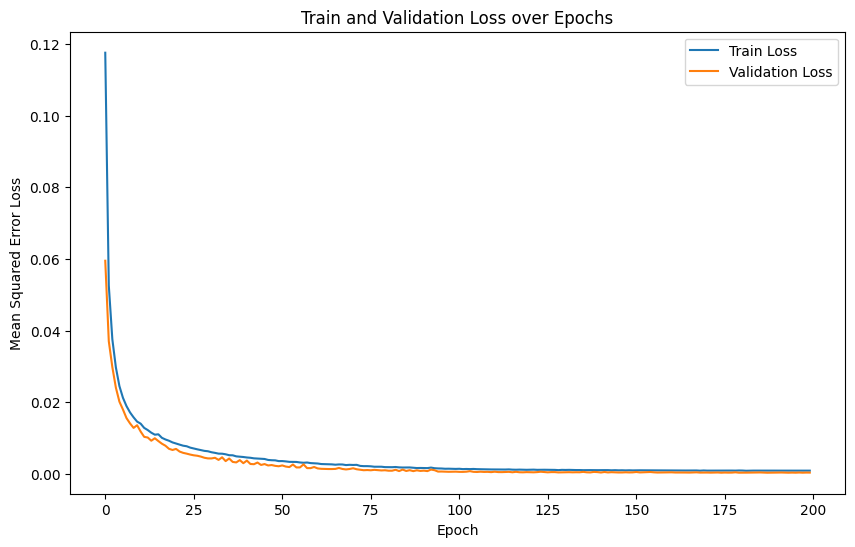

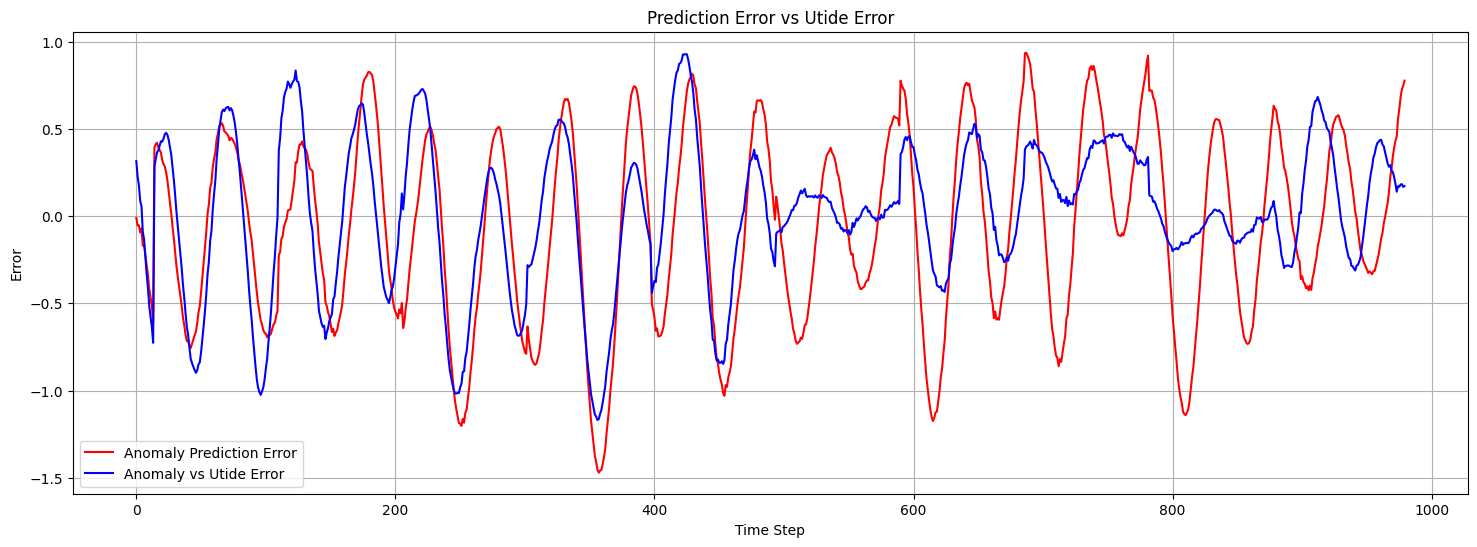

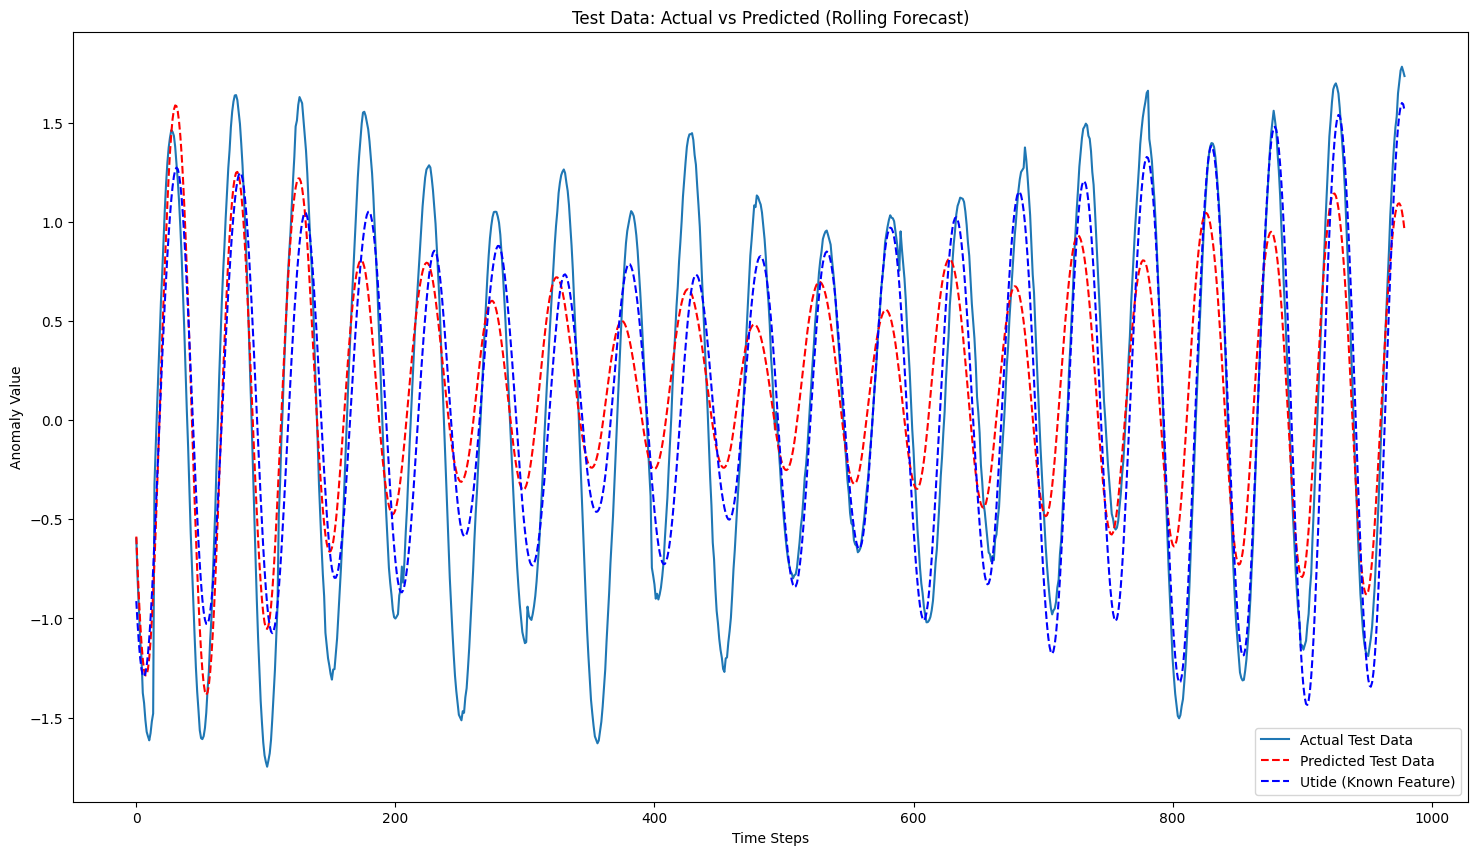

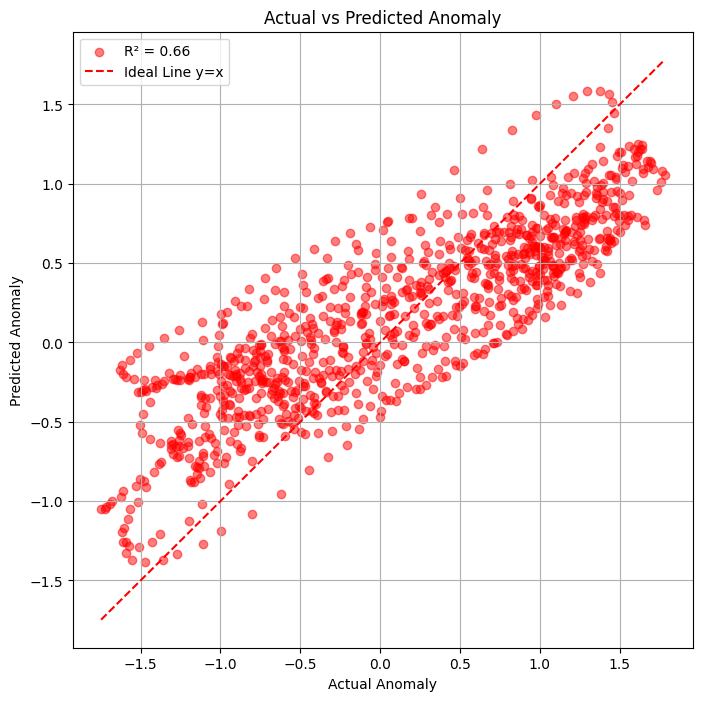

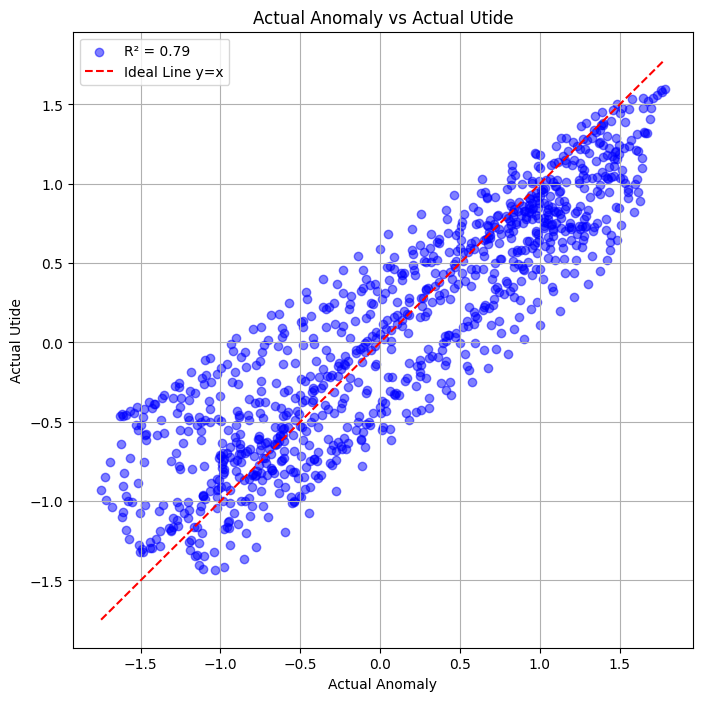

Error Metrics between Anomaly and Utide:
Utide MSE: 0.10
Utide MAE: 0.23
Utide R²: 0.79
Test RMSE: 0.54
Test MAE: 0.46
Test R²: 0.66


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

np.random.seed(5)

#file path
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# load dataset
df = read_csv(input_file, delimiter=',')

total_length = len(df)

print(f"Total dataset length: {total_length}")

num_points = 12000

if total_length >= num_points:
    max_start_index = total_length - num_points
    np.random.seed(int(time.time()))
    start_index = np.random.randint(0, max_start_index + 1)
    end_index = start_index + num_points - 1

    start_time = df.iloc[start_index]['time']
    end_time = df.iloc[end_index]['time']

    df = df.iloc[start_index:end_index + 1]

    print(f"Selected data starts from index {start_index} and ends at index {end_index}.")
    print(f"Corresponding time range: from {start_time} to {end_time}.")
else:
    print("Dataset length is less than 10,000 rows, cannot select data.")

dataset = df[['anomaly', 'utide']].values

# scalar
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# data split
train_size = 11000
test_size = 1000
train = dataset[:train_size]
test = dataset[train_size:train_size + test_size]

look_back = 20

# create dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

num_features = trainX.shape[2]

# learning rate
learning_rate = 0.001
weight_decay = 0.0001

# BiLSTM
input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(250, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Bidirectional(LSTM(50, kernel_regularizer=l2(weight_decay)))(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

history = model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=512, verbose=1, callbacks=[reduce_lr])

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

current_input = testX[0]

utide_test = test[:, 1]

rolling_predictions = []

for i in range(len(testY)):
    current_input_reshaped = current_input.reshape(1, look_back, num_features)
    prediction = model.predict(current_input_reshaped, verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1, 0] = prediction[0, 0]
    current_input[-1, 1] = utide_test[look_back + i]

rolling_predictions = np.array(rolling_predictions)

predictions_full = np.zeros((len(rolling_predictions), num_features))
predictions_full[:, 0] = rolling_predictions
predictions_full[:, 1] = test[look_back:, 1]

testY_full = np.zeros((len(testY), num_features))
testY_full[:, 0] = testY
testY_full[:, 1] = test[look_back:, 1]

predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

aligned_utide = utide_inverse
error_anomaly = testY_inverse - predictions_inverse
error_utide = testY_inverse - utide_inverse

plt.figure(figsize=(18, 6))
plt.plot(error_anomaly, label='Anomaly Prediction Error', color='red')
plt.plot(error_utide, label='Anomaly vs Utide Error', color='blue')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Prediction Error vs Utide Error')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="Actual Test Data")
plt.plot(predictions_inverse, label="Predicted Test Data", color='red', linestyle="--")
plt.plot(aligned_utide, label="Utide (Known Feature)", color='blue', linestyle="--", linewidth=1.5)
plt.xlabel("Time Steps")
plt.ylabel("Anomaly Value")
plt.title("Test Data: Actual vs Predicted (Rolling Forecast)")
plt.legend()
plt.show()

anomaly_values = df['anomaly'].values
utide_values = df['utide'].values

mse_utide_anomaly = mean_squared_error(anomaly_values, utide_values)
mae_utide_anomaly = mean_absolute_error(anomaly_values, utide_values)
r2_utide_anomaly = r2_score(testY_inverse, utide_inverse)

assert len(testY_inverse) == len(predictions_inverse) == len(utide_inverse), "Data length mismatch"

r2_pred = r2_score(testY_inverse, predictions_inverse)
r2_utide = r2_score(testY_inverse, utide_inverse)

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, predictions_inverse, alpha=0.5, label=f'R² = {r2_pred:.2f}', color='red')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'r--', label='Ideal Line y=x')
plt.xlabel('Actual Anomaly')
plt.ylabel('Predicted Anomaly')
plt.title('Actual vs Predicted Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, utide_inverse, alpha=0.5, label=f'R² = {r2_utide:.2f}', color='blue')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'r--', label='Ideal Line y=x')
plt.xlabel('Actual Anomaly')
plt.ylabel('Actual Utide')
plt.title('Actual Anomaly vs Actual Utide')
plt.legend()
plt.grid(True)
plt.show()

print("Error Metrics between Anomaly and Utide:")
print(f"Utide MSE: {mse_utide_anomaly:.2f}")
print(f"Utide MAE: {mae_utide_anomaly:.2f}")
print(f"Utide R²: {r2_utide_anomaly:.2f}")
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.2381 - val_loss: 0.1189 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1128 - val_loss: 0.0788 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0773 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0581 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0479 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0414 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0372 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0337 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0308 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 10/2

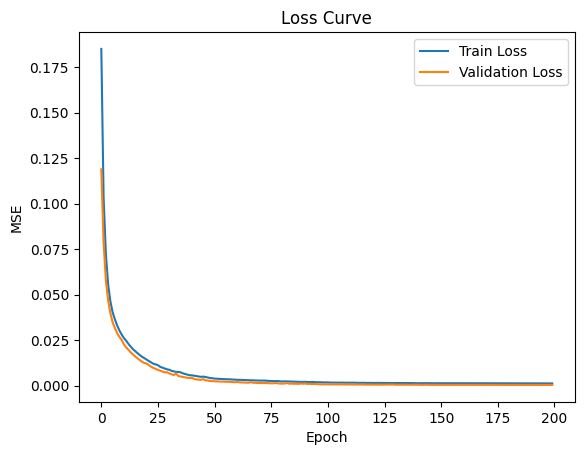

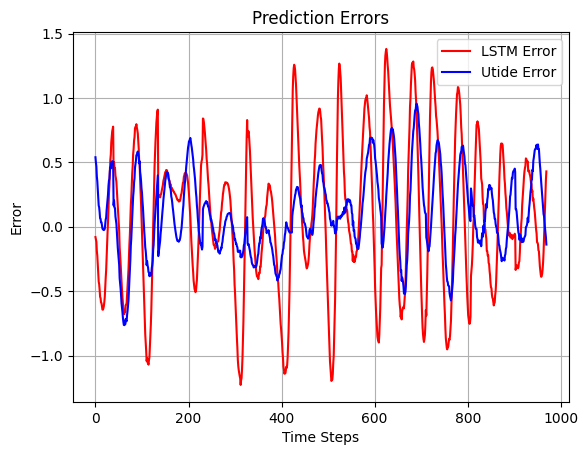

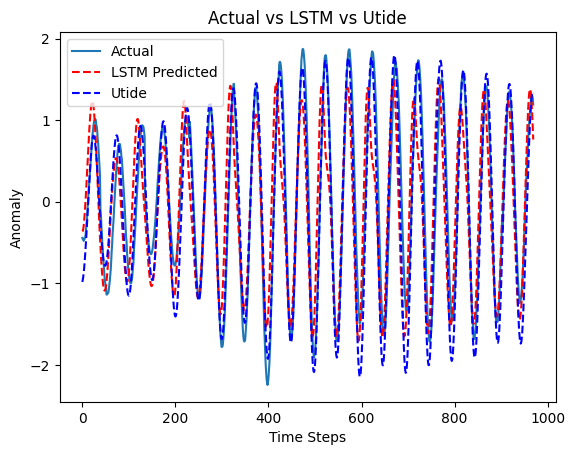

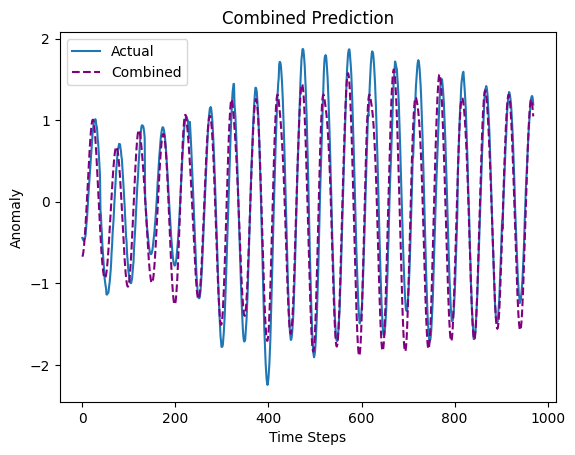

LSTM RMSE: 0.58, MAE: 0.48, R²: 0.69
Harmonic RMSE: 0.33
Combined RMSE: 0.39, MAE: 0.32, R²: 0.86


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

np.random.seed(5)

# Load dataset
input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = read_csv(input_file, delimiter=',')

# Select 12,000 continuous data points
num_points = 12000
if len(df) >= num_points:
    start_index = np.random.randint(0, len(df) - num_points + 1)
    df = df.iloc[start_index:start_index + num_points]
else:
    raise ValueError("Dataset is too small.")

# Normalize data
dataset = df[['anomaly', 'utide']].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train/test sets
train_size = 11000
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:]

# Create dataset function
look_back = 30
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:i + look_back, :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Build BiLSTM model
input_layer = Input(shape=(look_back, trainX.shape[2]))
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
x = Bidirectional(LSTM(50, kernel_regularizer=l2(0.0001)))(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.5 if epoch % 50 == 0 and epoch != 0 else lr)
history = model.fit(trainX, trainY, validation_split=0.1, epochs=200, batch_size=512, verbose=1, callbacks=[reduce_lr, lr_scheduler])

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Rolling prediction
current_input = testX[0].copy()
utide_test = test[:, 1]
rolling_predictions = []
for i in range(len(testY)):
    prediction = model.predict(current_input.reshape(1, look_back, trainX.shape[2]), verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1, 0] = prediction[0, 0]
    current_input[-1, 1] = utide_test[look_back + i]

rolling_predictions = np.array(rolling_predictions)

# Inverse transform predictions
predictions_full = np.zeros((len(rolling_predictions), trainX.shape[2]))
predictions_full[:, 0] = rolling_predictions
predictions_full[:, 1] = test[look_back:, 1]
testY_full = np.zeros((len(testY), trainX.shape[2]))
testY_full[:, 0] = testY
testY_full[:, 1] = test[look_back:, 1]
predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

# Calculate metrics
rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

# Plot errors
plt.plot(testY_inverse - predictions_inverse, label='LSTM Error', color='red')
plt.plot(testY_inverse - utide_inverse, label='Utide Error', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.title('Prediction Errors')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted
plt.plot(testY_inverse, label="Actual")
plt.plot(predictions_inverse, label="LSTM Predicted", linestyle="--", color='red')
plt.plot(utide_inverse, label="Utide", linestyle="--", color='blue')
plt.xlabel("Time Steps")
plt.ylabel("Anomaly")
plt.title("Actual vs LSTM vs Utide")
plt.legend()
plt.show()

# Weighted average prediction
combined_predictions_inverse = 0.5 * predictions_inverse + 0.5 * utide_inverse
rmse_combined = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
mae_combined = mean_absolute_error(testY_inverse, combined_predictions_inverse)
r2_combined = r2_score(testY_inverse, combined_predictions_inverse)

plt.plot(testY_inverse, label="Actual")
plt.plot(combined_predictions_inverse, label="Combined", linestyle="--", color='purple')
plt.xlabel("Time Steps")
plt.ylabel("Anomaly")
plt.title("Combined Prediction")
plt.legend()
plt.show()

# Print metrics
print(f'LSTM RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')
print(f'Harmonic RMSE: {math.sqrt(mean_squared_error(testY_inverse, utide_inverse)):.2f}')
print(f'Combined RMSE: {rmse_combined:.2f}, MAE: {mae_combined:.2f}, R²: {r2_combined:.2f}')

数据集总长度为：175296
选取的数据从索引 43497 开始，到索引 55496 结束。
对应的时间范围：从 2020-03-29 02:15:00 到 2020-08-01 02:00:00。
训练集大小: 11000, 测试集大小: 1000
训练集X形状: (10970, 30, 2), 训练集Y形状: (10970,)
测试集X形状: (970, 30, 2), 测试集Y形状: (970,)
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.2422 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1149 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0556 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0410 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0331 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0285 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0256 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━

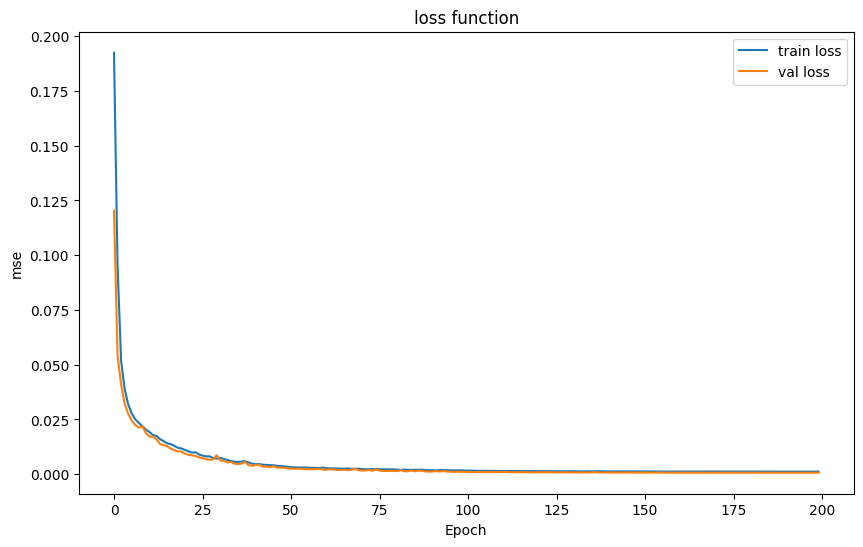

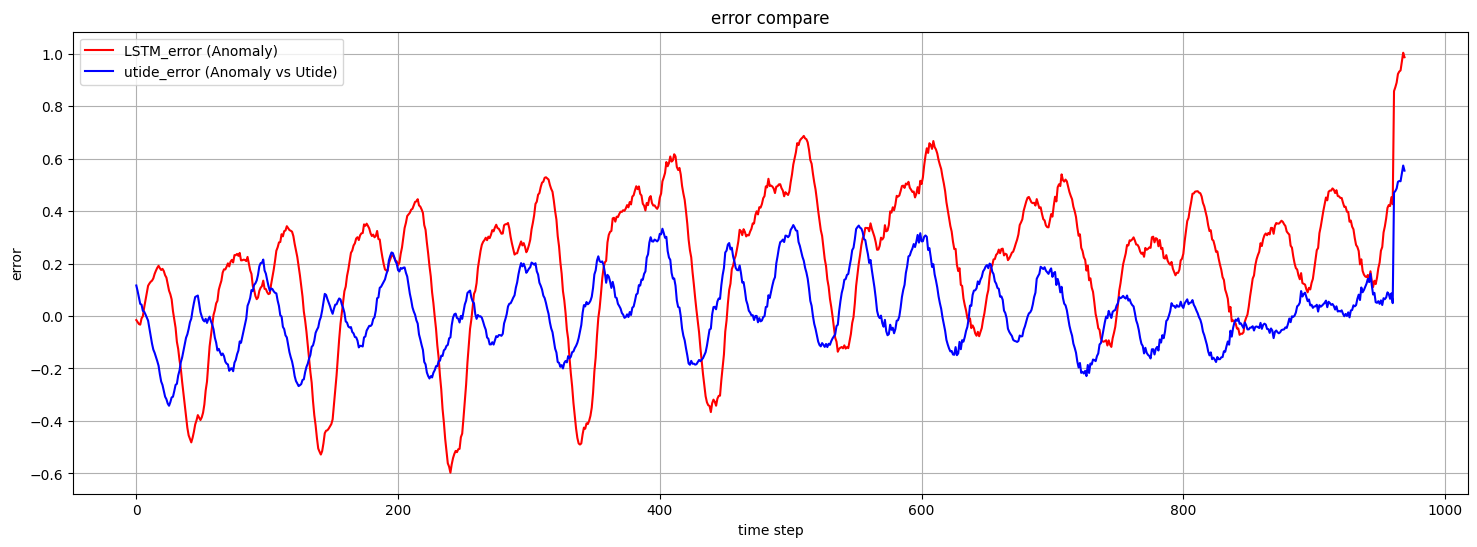

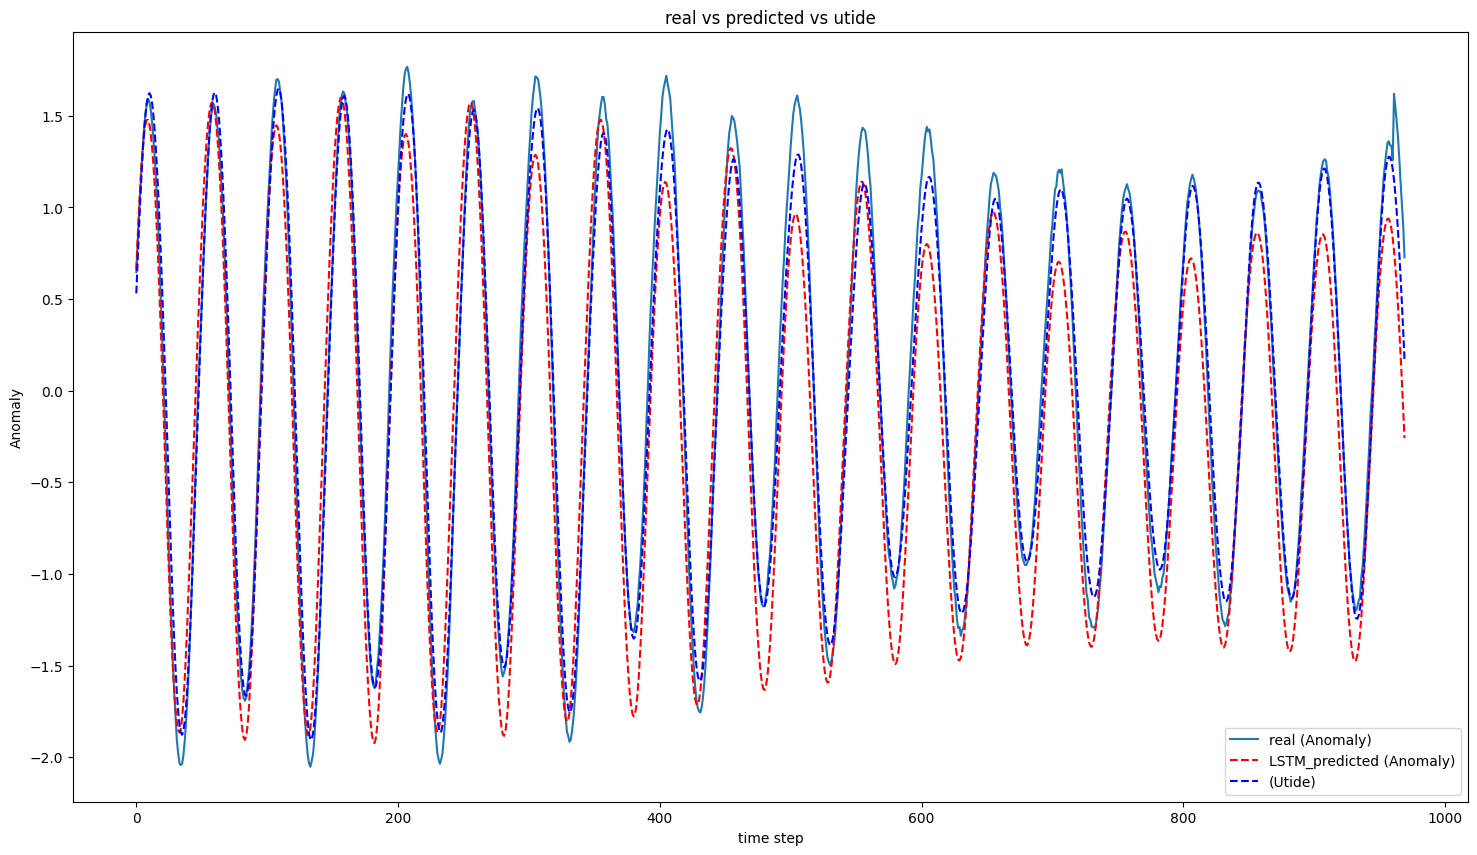

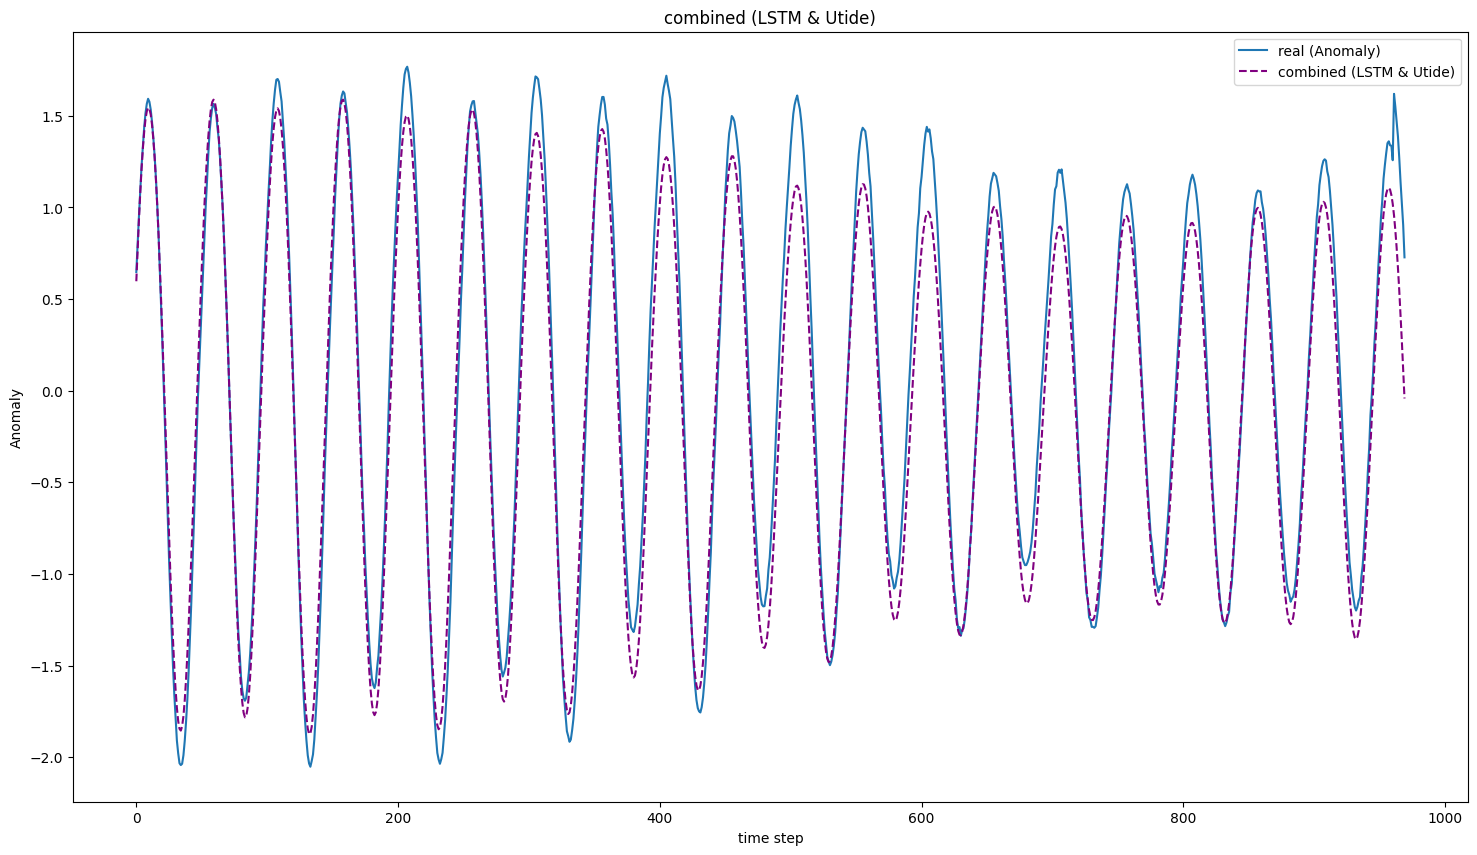

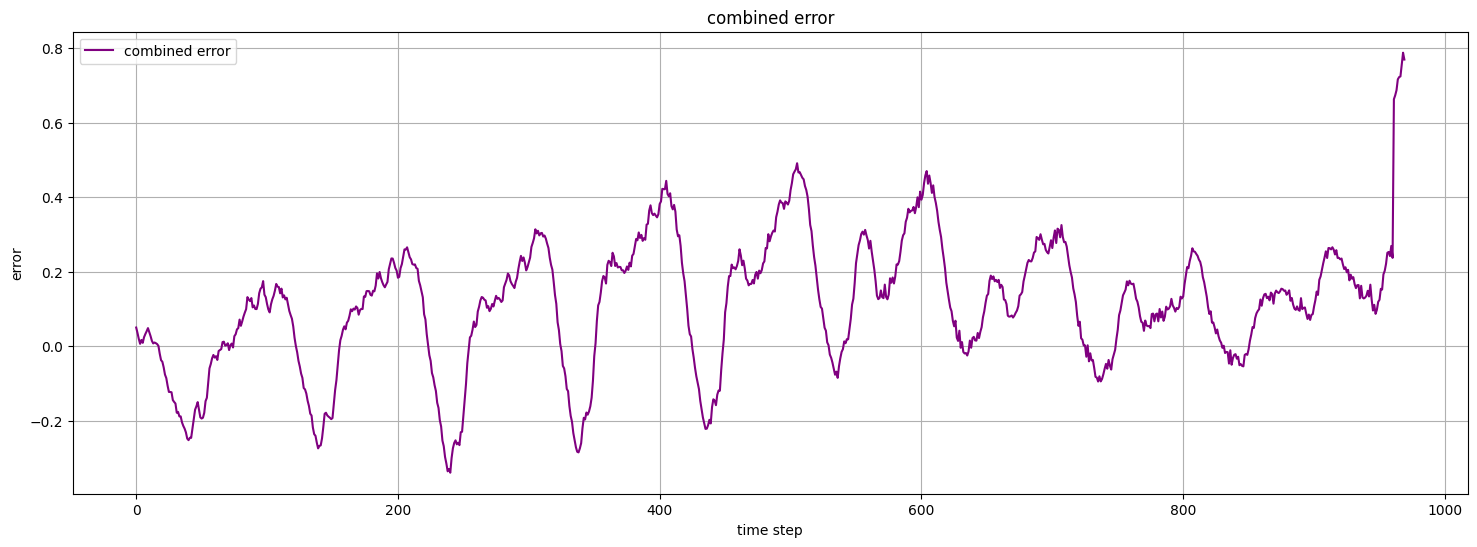

各模型的误差指标：

LSTM 模型的误差指标：
Test RMSE: 0.34
Test MAE: 0.30
Test R²: 0.89

谐波分析的误差指标：
Harmonic RMSE: 0.15
Harmonic MAE: 0.11
Harmonic R²: 0.98

加权平均预测的误差指标：
Combined RMSE: 0.21
Combined MAE: 0.17
Combined R²: 0.96


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


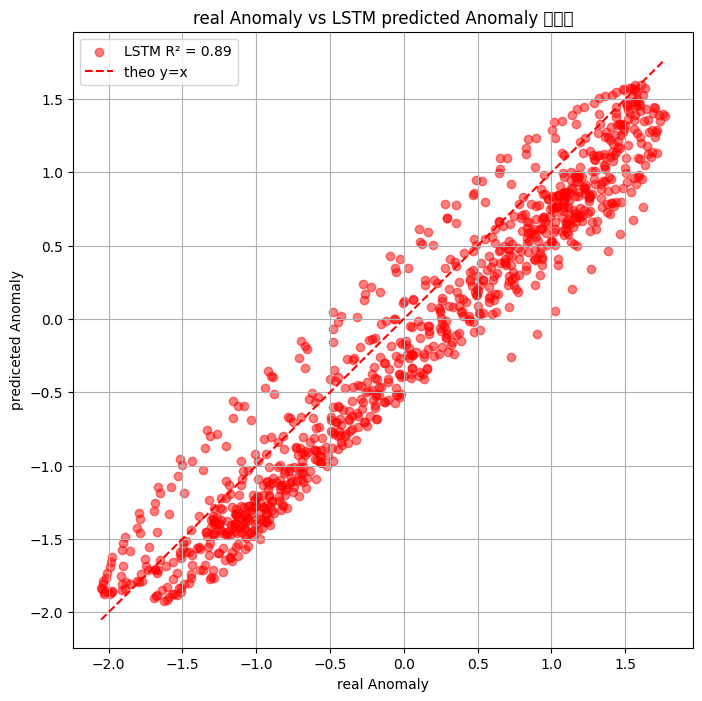

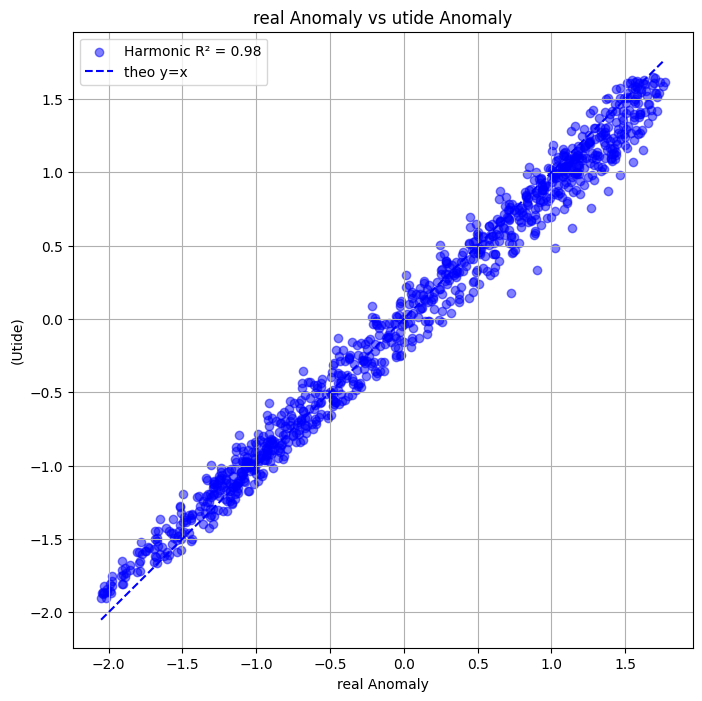

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24819 (\N{CJK UNIFIED IDEOGRAPH-60F3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


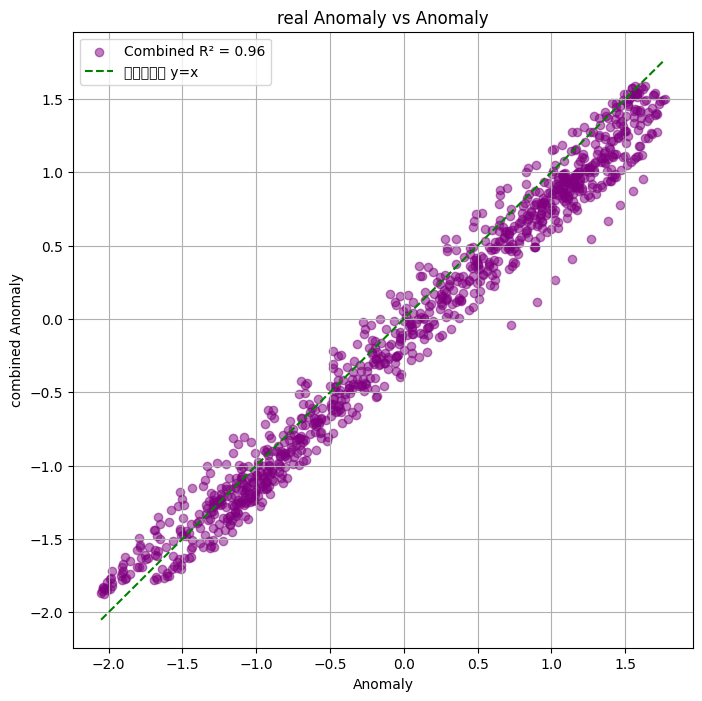

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input, Layer
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

np.random.seed(5)

from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

df = read_csv(input_file, delimiter=',')

total_length = len(df)
print(f"数据集总长度为：{total_length}")

num_points = 12000

if total_length >= num_points:
    max_start_index = total_length - num_points
    np.random.seed(int(time.time()))
    start_index = np.random.randint(0, max_start_index + 1)
    end_index = start_index + num_points - 1


    start_time = df.iloc[start_index]['time']
    end_time = df.iloc[end_index]['time']

    df = df.iloc[start_index:end_index + 1]

    print(f"选取的数据从索引 {start_index} 开始，到索引 {end_index} 结束。")
    print(f"对应的时间范围：从 {start_time} 到 {end_time}。")
else:
    print("数据集长度不足 12,000 行，无法选取。")

feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values

#scalar
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)


train_size = 11000
test_size = 1000
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:train_size + test_size]

print(f"训练集大小: {train.shape[0]}, 测试集大小: {test.shape[0]}")

look_back = 30

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"训练集X形状: {trainX.shape}, 训练集Y形状: {trainY.shape}")
print(f"测试集X形状: {testX.shape}, 测试集Y形状: {testY.shape}")

num_features = trainX.shape[2]

learning_rate = 0.001
weight_decay = 0.0001

input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer)
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(x)
x = Attention()(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

def scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=200,
    batch_size=512,
    verbose=1,
    callbacks=[reduce_lr, lr_scheduler]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.title('loss function')
plt.legend()
plt.show()

current_input = testX[0].copy()
utide_test = test[:, 1]

rolling_predictions = []

for i in range(len(testY)):
    current_input_reshaped = current_input.reshape(1, look_back, num_features)
    prediction = model.predict(current_input_reshaped, verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1, 0] = prediction[0, 0]
    current_input[-1, 1] = utide_test[look_back + i]

rolling_predictions = np.array(rolling_predictions)

predictions_full = np.zeros((len(rolling_predictions), num_features))
predictions_full[:, 0] = rolling_predictions
predictions_full[:, 1] = test[look_back:, 1]

testY_full = np.zeros((len(testY), num_features))
testY_full[:, 0] = testY
testY_full[:, 1] = test[look_back:, 1]

predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

aligned_utide = utide_inverse

error_anomaly = testY_inverse - predictions_inverse
error_utide = testY_inverse - utide_inverse

plt.figure(figsize=(18, 6))
plt.plot(error_anomaly, label='LSTM_error (Anomaly)', color='red')
plt.plot(error_utide, label='utide_error (Anomaly vs Utide)', color='blue')
plt.xlabel('time step')
plt.ylabel('error')
plt.title('error compare')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(predictions_inverse, label="LSTM_predicted (Anomaly)", color='red', linestyle="--")
plt.plot(aligned_utide, label="(Utide)", color='blue', linestyle="--", linewidth=1.5)
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("real vs predicted vs utide")
plt.legend()
plt.show()

alpha = 0.5
beta = 0.5

combined_predictions_inverse = alpha * predictions_inverse + beta * aligned_utide

rmse_combined = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
mae_combined = mean_absolute_error(testY_inverse, combined_predictions_inverse)
r2_combined = r2_score(testY_inverse, combined_predictions_inverse)

plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(combined_predictions_inverse, label="combined (LSTM & Utide)", color='purple', linestyle="--")
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("combined (LSTM & Utide)")
plt.legend()
plt.show()

error_combined = testY_inverse - combined_predictions_inverse

plt.figure(figsize=(18, 6))
plt.plot(error_combined, label='combined error', color='purple')
plt.xlabel('time step')
plt.ylabel('error')
plt.title('combined error')
plt.legend()
plt.grid(True)
plt.show()


print("各模型的误差指标：\n")

print("LSTM 模型的误差指标：")
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

print("\n谐波分析的误差指标：")
harmonic_rmse = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))
harmonic_mae = mean_absolute_error(testY_inverse, utide_inverse)
harmonic_r2 = r2_score(testY_inverse, utide_inverse)
print(f'Harmonic RMSE: {harmonic_rmse:.2f}')
print(f'Harmonic MAE: {harmonic_mae:.2f}')
print(f'Harmonic R²: {harmonic_r2:.2f}')

print("\n加权平均预测的误差指标：")
print(f'Combined RMSE: {rmse_combined:.2f}')
print(f'Combined MAE: {mae_combined:.2f}')
print(f'Combined R²: {r2_combined:.2f}')

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, predictions_inverse, alpha=0.5, label=f'LSTM R² = {r2:.2f}', color='red')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'r--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('prediceted Anomaly')
plt.title('real Anomaly vs LSTM predicted Anomaly 的关系')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, utide_inverse, alpha=0.5, label=f'Harmonic R² = {harmonic_r2:.2f}', color='blue')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'b--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('(Utide)')
plt.title('real Anomaly vs utide Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, combined_predictions_inverse, alpha=0.5, label=f'Combined R² = {r2_combined:.2f}', color='purple')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'g--', label='理想对角线 y=x')
plt.xlabel('Anomaly')
plt.ylabel('combined Anomaly')
plt.title('real Anomaly vs Anomaly')
plt.legend()
plt.grid(True)
plt.show()

Iteration 1/10
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1132 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 9.5159e-04 - learning_rate

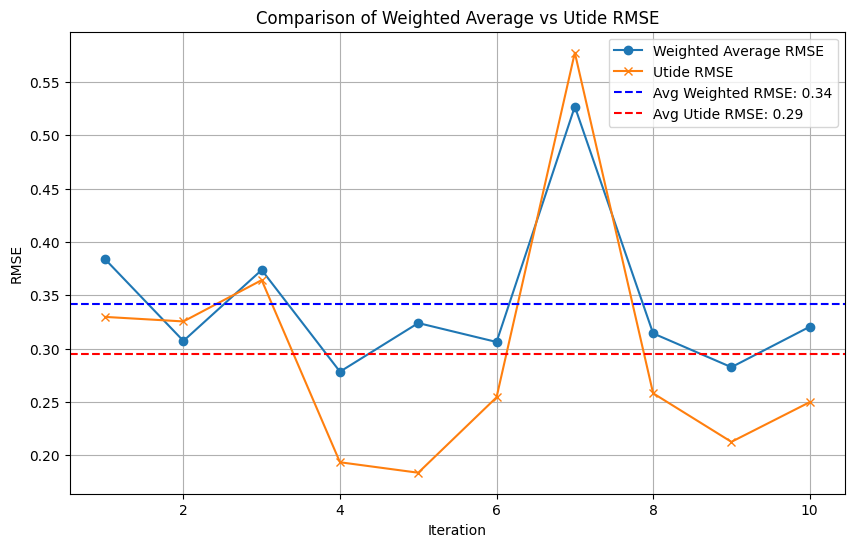

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

np.random.seed(5)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = read_csv(input_file, delimiter=',')

feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values

#scalar
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

#parameters
look_back = 50
train_size = 11000
test_size = 1000
num_points = train_size + test_size

# Weights
alpha, beta = 0.5, 0.5

# Store errors
weighted_errors, utide_errors = [], []

# create dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#10 iterations
for iteration in range(10):
    print(f"Iteration {iteration + 1}/10")

    # Randomly select 12,000 rows
    total_length = len(dataset_scaled)
    start_index = np.random.randint(0, total_length - num_points + 1)
    selected_data = dataset_scaled[start_index:start_index + num_points]

    # Split into train and test sets
    train, test = selected_data[:train_size], selected_data[train_size:train_size + test_size]

    # Create train and test datasets
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    num_features = trainX.shape[2]

    # Build LSTM model
    input_layer = Input(shape=(look_back, num_features))
    x = Bidirectional(LSTM(200, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)

    # Train model
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
    model.fit(trainX, trainY, validation_split=0.1, epochs=100, batch_size=512, verbose=1, callbacks=[reduce_lr])

    # Rolling prediction
    current_input = testX[0].copy()
    utide_test = test[:, 1]
    rolling_predictions = []
    for i in range(len(testY)):
        current_input_reshaped = current_input.reshape(1, look_back, num_features)
        prediction = model.predict(current_input_reshaped, verbose=0)
        rolling_predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction[0, 0]
        current_input[-1, 1] = utide_test[look_back + i]

    # Convert to array
    rolling_predictions = np.array(rolling_predictions)

    # Inverse transform predictions
    predictions_full = np.zeros((len(rolling_predictions), num_features))
    predictions_full[:, 0] = rolling_predictions
    predictions_full[:, 1] = test[look_back:, 1]
    testY_full = np.zeros((len(testY), num_features))
    testY_full[:, 0] = testY
    testY_full[:, 1] = test[look_back:, 1]
    predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
    testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
    utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

    # Weighted average
    combined_predictions_inverse = alpha * predictions_inverse + beta * utide_inverse

    # Calculate errors
    rmse_weighted = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
    rmse_utide = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))
    weighted_errors.append(rmse_weighted)
    utide_errors.append(rmse_utide)

    print(f"Weighted Average RMSE: {rmse_weighted:.2f}")
    print(f"Utide RMSE: {rmse_utide:.2f}")

#average errors
avg_weighted_error = np.mean(weighted_errors)
avg_utide_error = np.mean(utide_errors)
print("\n======== Final Results ========")
print(f"Weighted Average RMSE (Mean over 10 runs): {avg_weighted_error:.2f}")
print(f"Utide RMSE (Mean over 10 runs): {avg_utide_error:.2f}")

# RMSE
plt.figure(figsize=(10, 6))
x_ticks = range(1, 11)
plt.plot(x_ticks, weighted_errors, marker='o', label='Weighted Average RMSE')
plt.plot(x_ticks, utide_errors, marker='x', label='Utide RMSE')
plt.axhline(avg_weighted_error, color='blue', linestyle='--', label=f'Avg Weighted RMSE: {avg_weighted_error:.2f}')
plt.axhline(avg_utide_error, color='red', linestyle='--', label=f'Avg Utide RMSE: {avg_utide_error:.2f}')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Comparison of Weighted Average vs Utide RMSE')
plt.legend()
plt.grid(True)
plt.show()

Iteration 1/10
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1214 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 9.5772e-04 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 8.7442e-04 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 9.6242e-04 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 9.4858e-04 - learning_rate: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 9.2615e-04 - learni

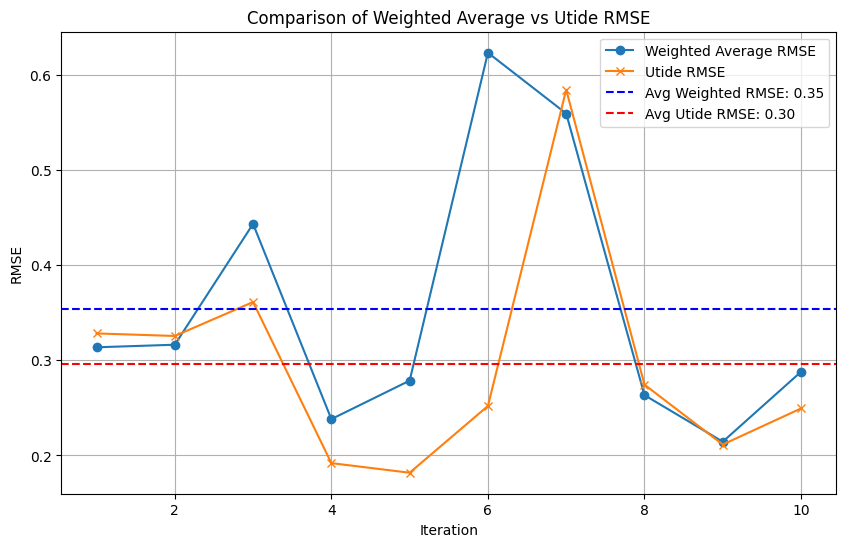

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

np.random.seed(5)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"

# load dataset
df = read_csv(input_file, delimiter=',')

feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values

#scalar
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

look_back = 30
train_size = 11000
test_size = 1000
num_points = train_size + test_size
# Weight
alpha = 0.5  # LSTm
beta = 0.5   # ha

# Store error results
weighted_errors = []
utide_errors = []

# create dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

for iteration in range(10):
    print(f"Iteration {iteration + 1}/10")

    total_length = len(dataset_scaled)
    max_start_index = total_length - num_points
    start_index = np.random.randint(0, max_start_index + 1)
    selected_data = dataset_scaled[start_index:start_index + num_points]

    # Split
    train, test = selected_data[:train_size], selected_data[train_size:train_size + test_size]

    # Create train and test datasets
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    num_features = trainX.shape[2]

    #LSTM
    input_layer = Input(shape=(look_back, num_features))
    x = Bidirectional(LSTM(200, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
    model.fit(trainX, trainY, validation_split=0.1, epochs=50, batch_size=512, verbose=1, callbacks=[reduce_lr])

    # Rolling prediction
    current_input = testX[0].copy()
    utide_test = test[:, 1]
    rolling_predictions = []
    for i in range(len(testY)):
        current_input_reshaped = current_input.reshape(1, look_back, num_features)
        prediction = model.predict(current_input_reshaped, verbose=0)
        rolling_predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction[0, 0]
        current_input[-1, 1] = utide_test[look_back + i]

    rolling_predictions = np.array(rolling_predictions)

    predictions_full = np.zeros((len(rolling_predictions), num_features))
    predictions_full[:, 0] = rolling_predictions
    predictions_full[:, 1] = test[look_back:, 1]

    testY_full = np.zeros((len(testY), num_features))
    testY_full[:, 0] = testY
    testY_full[:, 1] = test[look_back:, 1]

    predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
    testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
    utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

    combined_predictions_inverse = alpha * predictions_inverse + beta * utide_inverse

    # errors
    rmse_weighted = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
    rmse_utide = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))

    weighted_errors.append(rmse_weighted)
    utide_errors.append(rmse_utide)

    print(f"Weighted Average RMSE: {rmse_weighted:.2f}")
    print(f"Utide RMSE: {rmse_utide:.2f}")

avg_weighted_error = np.mean(weighted_errors)
avg_utide_error = np.mean(utide_errors)

print("\n======== Final Results ========")
print(f"Weighted Average RMSE (Mean over 10 runs): {avg_weighted_error:.2f}")
print(f"Utide RMSE (Mean over 10 runs): {avg_utide_error:.2f}")

# error
plt.figure(figsize=(10, 6))
x_ticks = range(1, 11)
plt.plot(x_ticks, weighted_errors, marker='o', label='Weighted Average RMSE')
plt.plot(x_ticks, utide_errors, marker='x', label='Utide RMSE')
plt.axhline(avg_weighted_error, color='blue', linestyle='--', label=f'Avg Weighted RMSE: {avg_weighted_error:.2f}')
plt.axhline(avg_utide_error, color='red', linestyle='--', label=f'Avg Utide RMSE: {avg_utide_error:.2f}')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Comparison of Weighted Average vs Utide RMSE')
plt.legend()
plt.grid(True)
plt.show()

total length：175296
train set: 11000, test set: 1000
trainX: (10970, 30, 2), trainY: (10970,)
testX: (970, 30, 2), testY: (970,)
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1348 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0565 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0017 - learning_rate

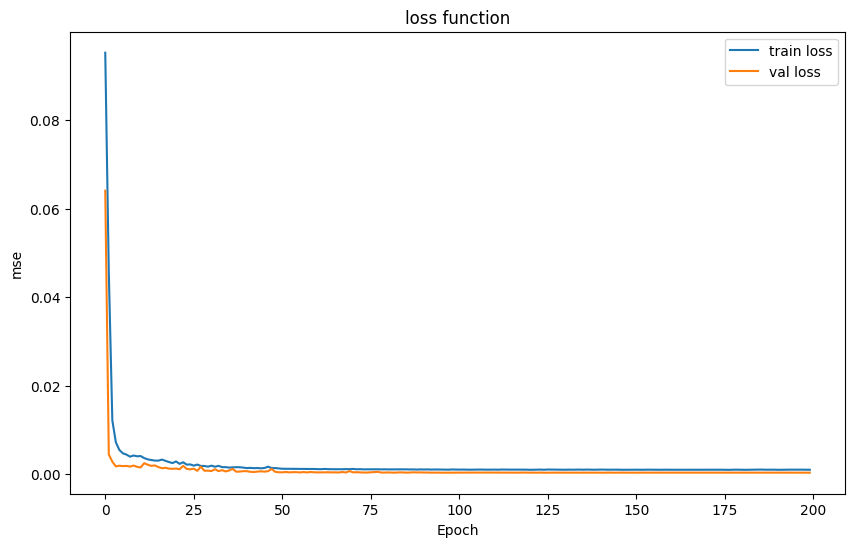

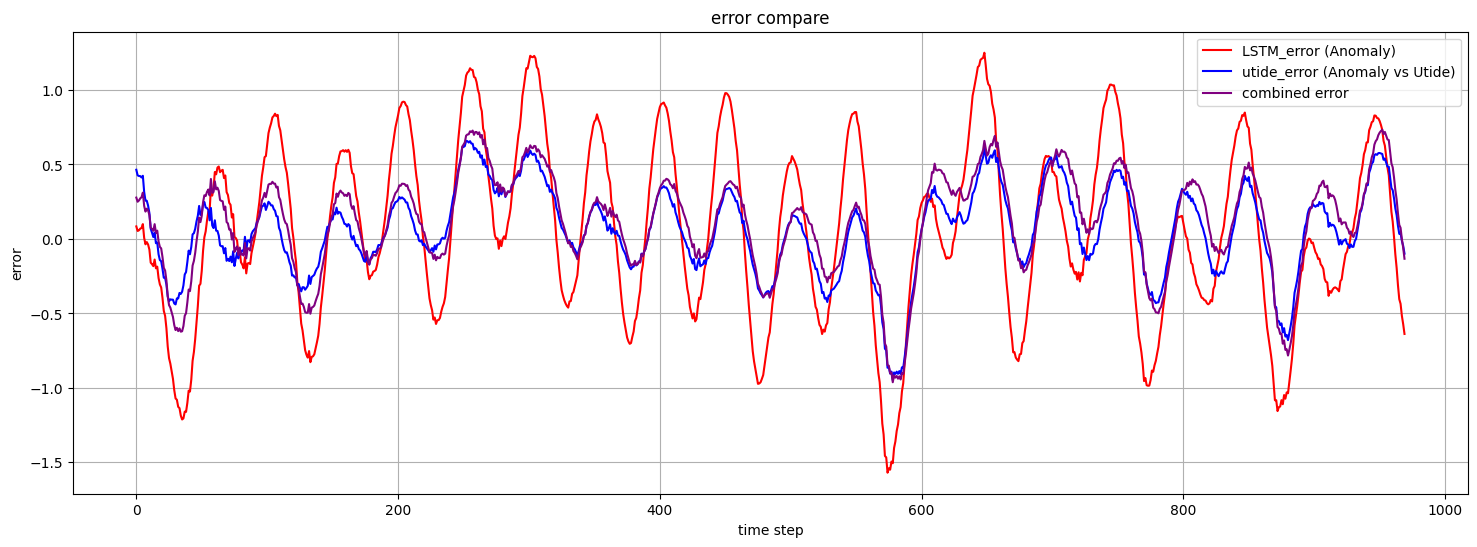

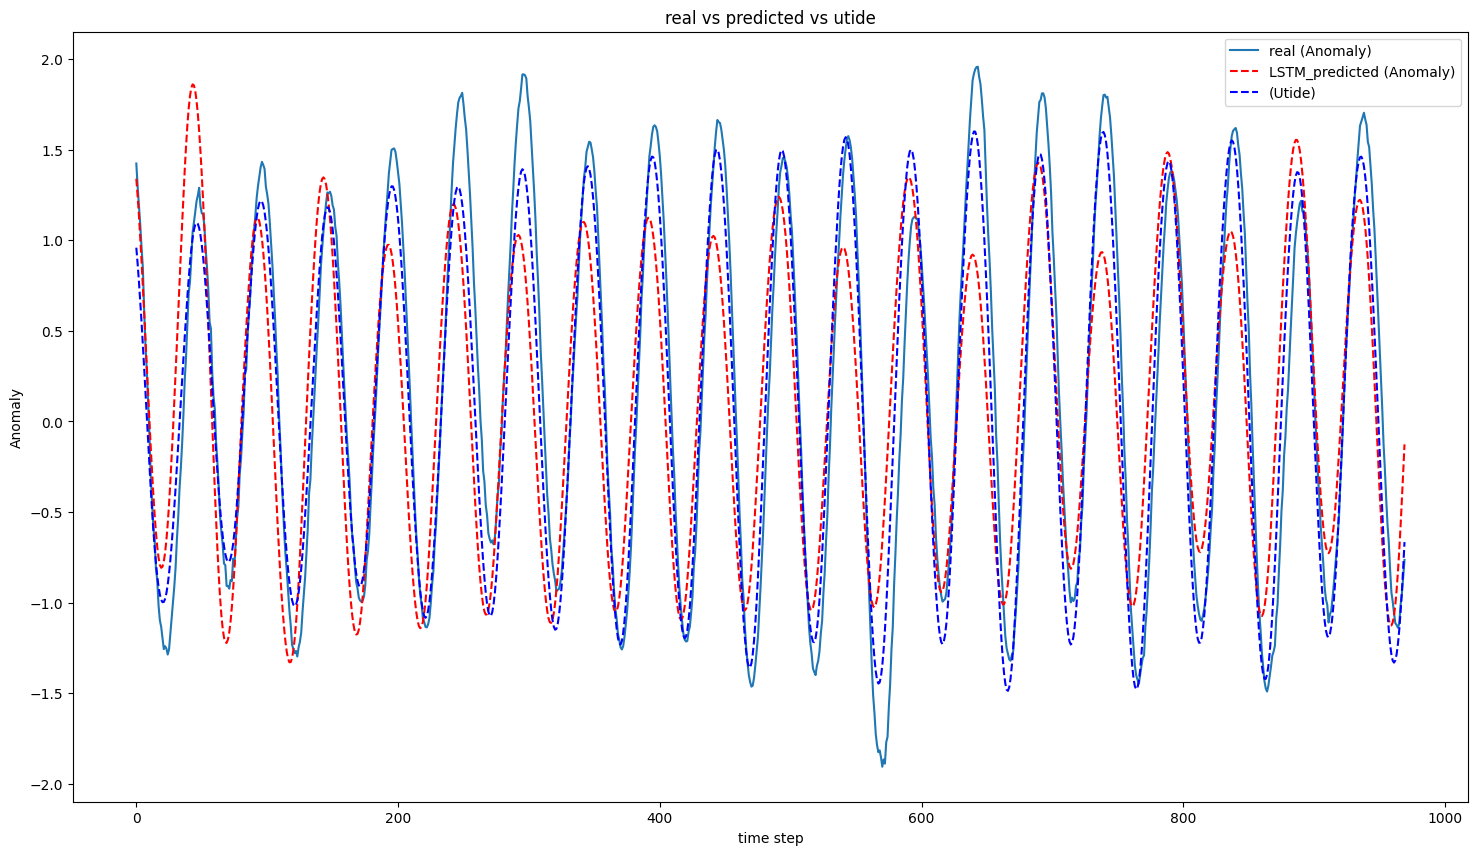

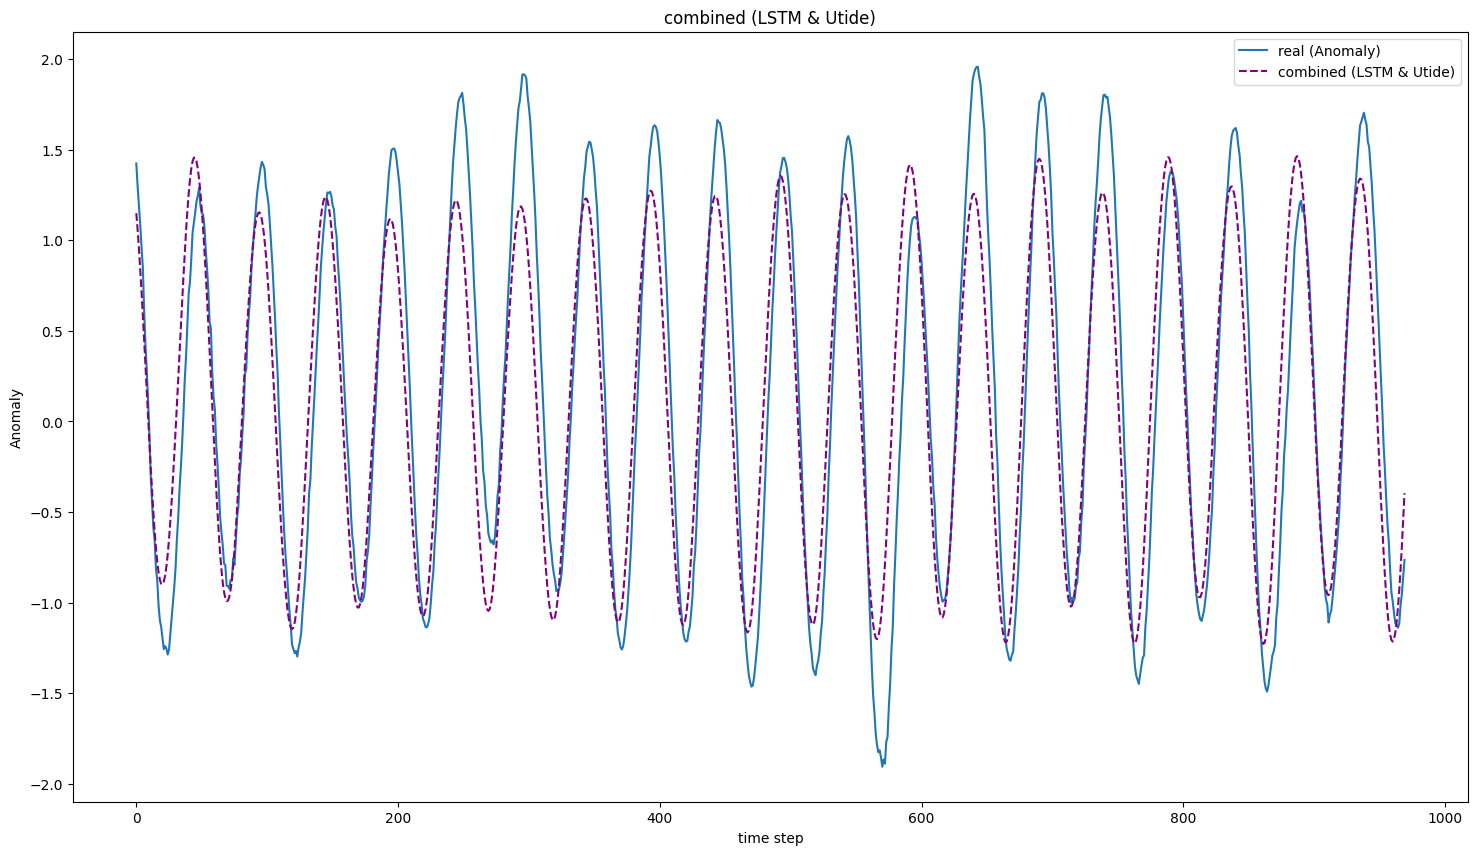

LSTM eva：
Test RMSE: 0.59
Test MAE: 0.49
Test R²: 0.65

eva：
Harmonic RMSE: 0.30
Harmonic MAE: 0.24
Harmonic R²: 0.91

weighted combined：
Combined RMSE: 0.43
Combined MAE: 0.34
Combined R²: 0.82


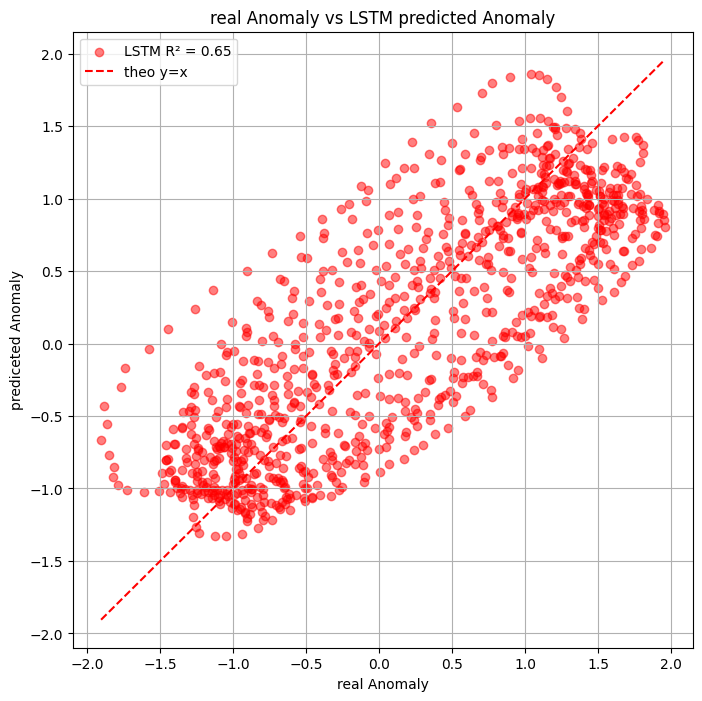

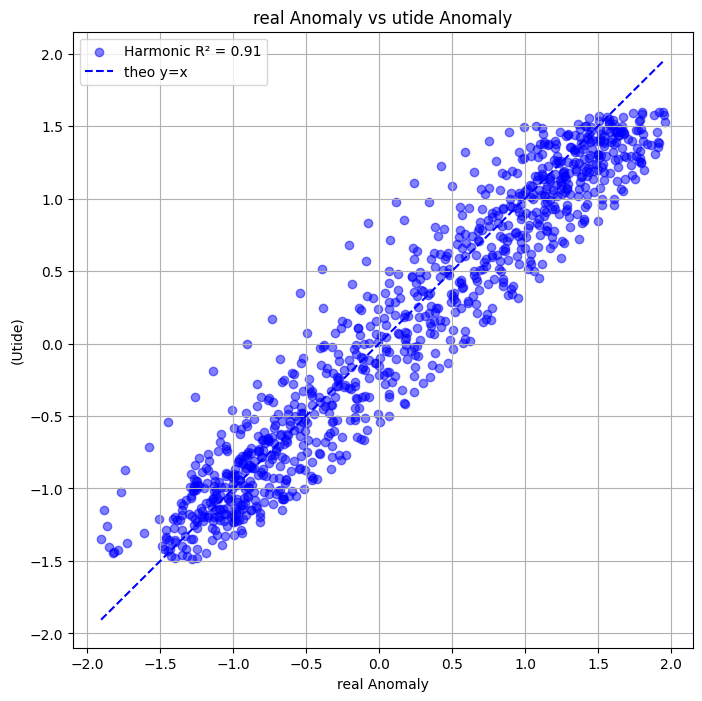

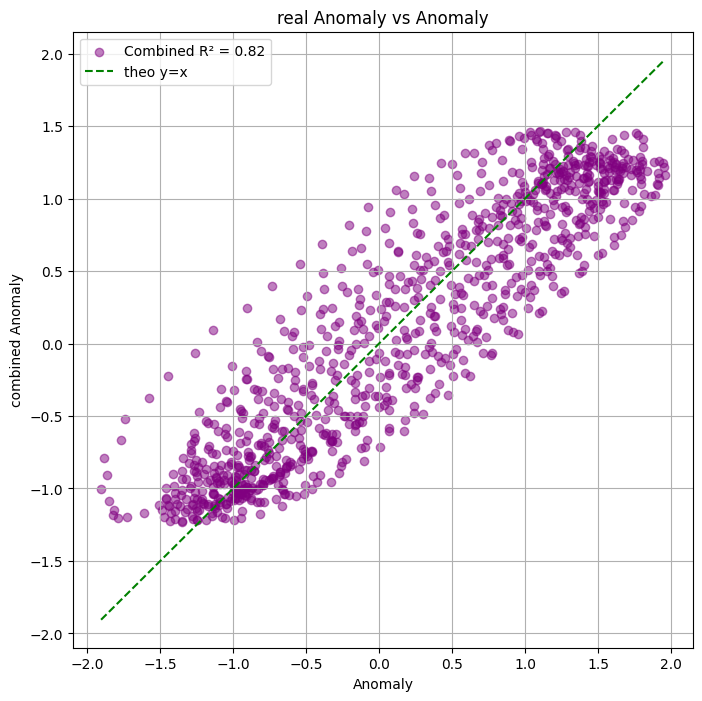

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input, Layer
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

np.random.seed(5)

# attention
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = read_csv(input_file, delimiter=',')
total_length = len(df)
print(f"total length：{total_length}")

num_points = 12000
if len(df) >= num_points:
    df = df.iloc[-num_points:]
else:
    raise ValueError("less data")
feature_columns = ['anomaly', 'utide']
dataset = df[feature_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)
train_size = 11000
test_size = 1000
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:train_size + test_size]

print(f"train set: {train.shape[0]}, test set: {test.shape[0]}")
look_back = 30
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"trainX: {trainX.shape}, trainY: {trainY.shape}")
print(f"testX: {testX.shape}, testY: {testY.shape}")
num_features = trainX.shape[2]
learning_rate = 0.001
weight_decay = 0.0001
#model
input_layer = Input(shape=(look_back, num_features))
x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(input_layer)
#x = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(weight_decay)))(x)
x = Attention()(x)
x = Dropout(0.4)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
def scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

#train
history = model.fit(
    trainX, trainY,
    validation_split=0.1,
    epochs=200,
    batch_size=512,
    verbose=1,
    callbacks=[reduce_lr, lr_scheduler]
)

#lossfunction
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.title('loss function')
plt.legend()
plt.show()

#rolling forcast
current_input = testX[0].copy()
utide_test = test[:, 1]
rolling_predictions = []
for i in range(len(testY)):
    current_input_reshaped = current_input.reshape(1, look_back, num_features)
    prediction = model.predict(current_input_reshaped, verbose=0)
    rolling_predictions.append(prediction[0, 0])
    current_input = np.roll(current_input, -1, axis=0)
    current_input[-1, 0] = prediction[0, 0]
    current_input[-1, 1] = utide_test[look_back + i]

rolling_predictions = np.array(rolling_predictions)
predictions_full = np.zeros((len(rolling_predictions), num_features))
predictions_full[:, 0] = rolling_predictions
predictions_full[:, 1] = test[look_back:, 1]

testY_full = np.zeros((len(testY), num_features))
testY_full[:, 0] = testY
testY_full[:, 1] = test[look_back:, 1]
#inverse
predictions_inverse = scaler.inverse_transform(predictions_full)[:, 0]
testY_inverse = scaler.inverse_transform(testY_full)[:, 0]
utide_inverse = scaler.inverse_transform(test[look_back:])[:, 1]

#evaluate
rmse = math.sqrt(mean_squared_error(testY_inverse, predictions_inverse))
mae = mean_absolute_error(testY_inverse, predictions_inverse)
r2 = r2_score(testY_inverse, predictions_inverse)

aligned_utide = utide_inverse
error_anomaly = testY_inverse - predictions_inverse
error_utide = testY_inverse - utide_inverse



plt.figure(figsize=(18, 6))
plt.plot(error_anomaly, label='LSTM_error (Anomaly)', color='red')
plt.plot(error_utide, label='utide_error (Anomaly vs Utide)', color='blue')
plt.plot(error_combined, label='combined error', color='purple')
plt.xlabel('time step')
plt.ylabel('error')
plt.title('error compare')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(predictions_inverse, label="LSTM_predicted (Anomaly)", color='red', linestyle="--")
plt.plot(aligned_utide, label="(Utide)", color='blue', linestyle="--", linewidth=1.5)
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("real vs predicted vs utide")
plt.legend()
plt.show()


#weighted average
ls = 0.5
ha = 0.5


combined_predictions_inverse = ls * predictions_inverse + ha * aligned_utide


rmse_combined = math.sqrt(mean_squared_error(testY_inverse, combined_predictions_inverse))
mae_combined = mean_absolute_error(testY_inverse, combined_predictions_inverse)
r2_combined = r2_score(testY_inverse, combined_predictions_inverse)


plt.figure(figsize=(18, 10))
plt.plot(testY_inverse, label="real (Anomaly)")
plt.plot(combined_predictions_inverse, label="combined (LSTM & Utide)", color='purple', linestyle="--")
plt.xlabel("time step")
plt.ylabel("Anomaly")
plt.title("combined (LSTM & Utide)")
plt.legend()
plt.show()

# error_combined = testY_inverse - combined_predictions_inverse

# plt.figure(figsize=(18, 6))
# plt.plot(error_combined, label='combined error', color='purple')
# plt.xlabel('time step')
# plt.ylabel('error')
# plt.title('combined error')
# plt.legend()
# plt.grid(True)
# plt.show()



print("LSTM eva：")
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R²: {r2:.2f}')

print("\neva：")
harmonic_rmse = math.sqrt(mean_squared_error(testY_inverse, utide_inverse))
harmonic_mae = mean_absolute_error(testY_inverse, utide_inverse)
harmonic_r2 = r2_score(testY_inverse, utide_inverse)
print(f'Harmonic RMSE: {harmonic_rmse:.2f}')
print(f'Harmonic MAE: {harmonic_mae:.2f}')
print(f'Harmonic R²: {harmonic_r2:.2f}')

print("\nweighted combined：")
print(f'Combined RMSE: {rmse_combined:.2f}')
print(f'Combined MAE: {mae_combined:.2f}')
print(f'Combined R²: {r2_combined:.2f}')

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, predictions_inverse, alpha=0.5, label=f'LSTM R² = {r2:.2f}', color='red')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'r--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('prediceted Anomaly')
plt.title('real Anomaly vs LSTM predicted Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, utide_inverse, alpha=0.5, label=f'Harmonic R² = {harmonic_r2:.2f}', color='blue')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'b--', label='theo y=x')
plt.xlabel('real Anomaly')
plt.ylabel('(Utide)')
plt.title('real Anomaly vs utide Anomaly')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(testY_inverse, combined_predictions_inverse, alpha=0.5, label=f'Combined R² = {r2_combined:.2f}', color='purple')
plt.plot([testY_inverse.min(), testY_inverse.max()], [testY_inverse.min(), testY_inverse.max()], 'g--', label='theo y=x')
plt.xlabel('Anomaly')
plt.ylabel('combined Anomaly')
plt.title('real Anomaly vs Anomaly')
plt.legend()
plt.grid(True)
plt.show()